# Usage example: Multiverse Analysis

To conduct a multiverse analysis, the forking paths must be specified in a dictionary. Options can contain:

* strings
* numerical values
* boolean values
* comet dFC methods
* comet and bct graph measures
* any kind of function

In [3]:
from comet.multiverse import Multiverse

forking_paths = {
    "strings": ["Hello", "world"],
    "numbers": [1, 2, 4.2],
    "booleans": [True, False],

    "dfc_measures": [{
                        "name": "LeiDA",
                        "func": "comet.connectivity.LeiDA",
                        "args": {
                                "time_series": "ts"
                                }
                        },
                        {
                        "name": "JC11",
                        "func": "comet.connectivity.Jackknife",
                        "args": {
                                "time_series": "ts",
                                "windowsize": 11,
                                }
                        }],

    "graph_measures": [{
                        "name": "efficiency",
                        "func": "comet.graph.efficiency",
                        "args": {
                                "W": "W",
                                "local": True,
                                }
                        },
                        {
                        "name": "clustering",
                        "func": "comet.graph.clustering_coef",
                        "args": {
                                "W": "W",
                                }
                        }]
}

config = {
    "order": [
        ("strings", "numbers", "booleans", "dfc_measures", "graph_measures"),
        ("strings", "booleans", "numbers", "dfc_measures", "graph_measures"),
    ],
    "invalid_paths": [
        ("Hello", 4.2)
    ]
}

With the decisions and options defined, an analysis template has to be specified. This is similar to a standard analysis pipeline with three additional requirements:

* The template is required to be encapsulated in a dedicated function
* Required imports need to be within the template function
* Decision points need to be specified in double brackets: ```{{decision}}```

In this brief example, the corresponding string, number, and boolean decision will be printed in each universe. Then, connevtivity will be estimated with the corresponding dFC method, and a graph measure (local efficiency or clustering) is calculated:

In [4]:
def analysis_template():
    import os
    import numpy as np
    import comet

    print(f"Decision 1: {{strings}}")
    print(f"Decision 2: {{numbers}}")
    print(f"Decision 3:{{booleans}}")

    # Load example data and calculate dFC
    ts = comet.utils.load_example()
    dfc = {{dfc_measures}}

    # Calculate graph measure
    graph_measure = np.zeros((ts.shape[0], dfc.shape[1]))
    for i in range(dfc.shape[2]):
        W = dfc[:, :, i]
        W = comet.graph.handle_negative_weights(W, type="absolute")
        W = comet.graph.threshold(W, type="density", density=0.5)
        graph_measure[i] = {{graph_measures}}

    # Save the results
    result = {"graph_measure": graph_measure}
    comet.utils.save_universe_results(result)

The forking paths dictionary defines 5 decision points consisting of 2 options each. Thus, the resulting multiverse will contain 2⁵=32 universes. A ```Multiverse``` object has to be created and can then be used to create, run, summarize, and visualize the multiverse.

* ```multiverse.create()``` will generate Python scripts for all 32 universes. These scripts will be saved in a newly created ```example_multiverse/``` folder
* ```multiverse.summary()``` will print the decisions for every universe. This information is also available as a .csv in the ```example_multiverse/results/``` folder
* ```multiverse.run()``` will either run all or individual universes. If the computational resources allow for it, this can be parallelized by using e.g. ```multiverse.run(parallel=4)```

In [5]:
multiverse = Multiverse(name="example_multiverse")
multiverse.create(analysis_template, forking_paths, config)
multiverse.summary();

,Universe,Decision 1,Value 1,Decision 2,Value 2,Decision 3,Value 3,Decision 4,Value 4,Decision 5,Value 5
0,Universe_1,strings,Hello,numbers,1,booleans,True,dfc_measures,LeiDA,graph_measures,efficiency
1,Universe_2,strings,Hello,numbers,1,booleans,True,dfc_measures,LeiDA,graph_measures,clustering
2,Universe_3,strings,Hello,numbers,1,booleans,True,dfc_measures,JC11,graph_measures,efficiency
3,Universe_4,strings,Hello,numbers,1,booleans,True,dfc_measures,JC11,graph_measures,clustering
4,Universe_5,strings,Hello,numbers,1,booleans,False,dfc_measures,LeiDA,graph_measures,efficiency


You can now run individual universes by specifying a number, or run all of them (parallelization is also supported):

In [6]:
multiverse.run(universe=[1,2], parallel=2)

Starting analysis for universe(s): [1, 2]...
Running universe_2.py
Running universe_1.py
Decision 1: 'Hello'
Decision 2: 1
Decision 3:True
Decision 1: 'Hello'
Decision 2: 1
Decision 3:True
The multiverse analysis completed without any errors.


After this, the results from all universes can be loaded:

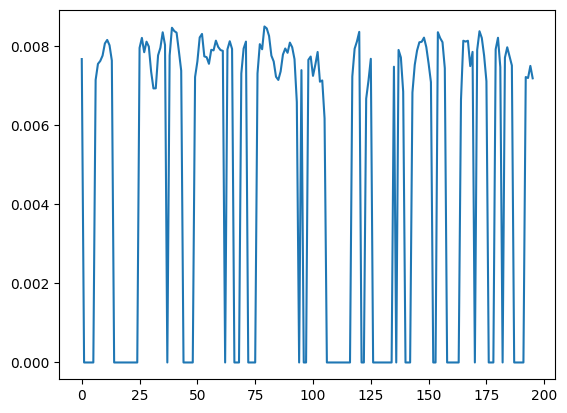

In [7]:
from matplotlib import pyplot as plt

results = multiverse.get_results()
plt.plot(results["universe_1"]["graph_measure"][:, 0]); # Nodal efficiency for the first ROI in universe 1